# 시계열 예측 전처리 + 모델링

### data import

In [14]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models, layers
import seaborn as sns

filename = 'dataset/shampoo-three-year.csv'

In [15]:
dataset = pd.read_csv(filename)

In [16]:
dataset = dataset.dropna()

In [17]:
dataset.shape

(36, 2)

### data preview

In [18]:
dataset.head(40)

,Month,Sales of shampoo over a three year period
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3
5,1901-06-01,168.5
6,1901-07-01,231.8
7,1901-08-01,224.5
8,1901-09-01,192.8
9,1901-10-01,122.9


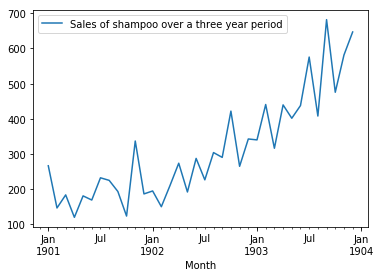

In [19]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
dataset.plot()
plt.show()

## data preprocessing

#### make n-step to n-step forecast dataset

In [20]:
dataset.values

array([[266. ],
       [145.9],
       [183.1],
       [119.3],
       [180.3],
       [168.5],
       [231.8],
       [224.5],
       [192.8],
       [122.9],
       [336.5],
       [185.9],
       [194.3],
       [149.5],
       [210.1],
       [273.3],
       [191.4],
       [287. ],
       [226. ],
       [303.6],
       [289.9],
       [421.6],
       [264.5],
       [342.3],
       [339.7],
       [440.4],
       [315.9],
       [439.3],
       [401.3],
       [437.4],
       [575.5],
       [407.6],
       [682. ],
       [475.3],
       [581.3],
       [646.9]])

In [21]:
"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_random_ordered(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        return train_test_split(x_data, y_data, test_size=test_size)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)
        

In [22]:
x_train, x_test, y_train, y_test = make_timeseries_dataset_random_ordered(series=dataset.values, x_steps=3, y_steps=1, test_size=0.2)

In [23]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (26, 3)
training Y data shape: (26, 1)
test X data shape: (7, 3)
test Y data shape: (7, 1)


# Modeling 1. Prophet

In [24]:
!pip install pystan fbprophet

Prophet follows the sklearn model API. 
We create an instance of the Prophet class and then call its fit and predict methods.

In [25]:
from fbprophet import Prophet

### banila prediction (monthly)

In [26]:
dataset = pd.read_csv(filename)
dataset.columns = ['ds', 'y']
dataset.head()

,ds,y
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3


In [27]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [28]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')

In [29]:
forecast_data = m.predict(future_data)

In [30]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,581.871518,503.675971,662.984548
33,1903-10-01,491.845550,408.336951,576.841930
34,1903-11-01,540.990388,460.442058,617.070640
35,1903-12-01,569.817744,489.242209,651.151953
36,1903-12-31,500.759688,416.637110,581.458631


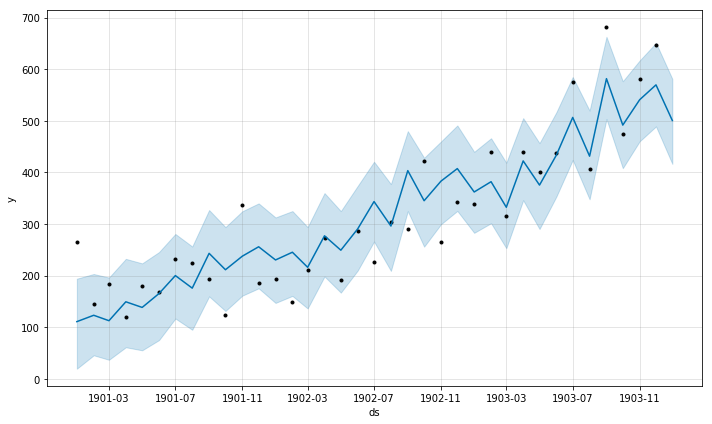

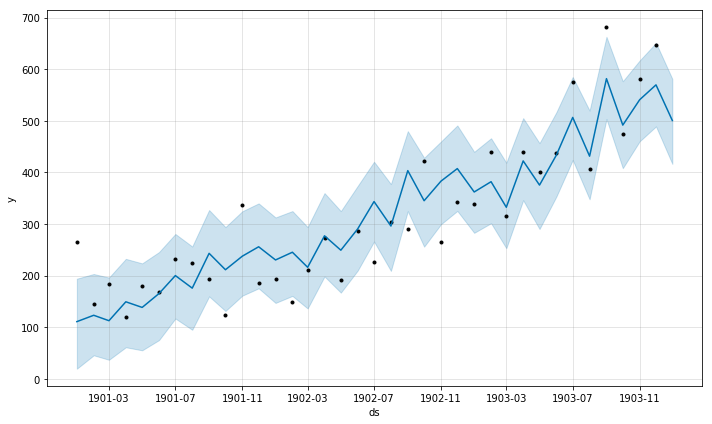

In [31]:
m.plot(forecast_data)

In [32]:
forecast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1901-01-01,117.291396,19.635497,194.105454,117.291396,117.291396,-0.054694,-0.054694,-0.054694,-0.054694,-0.054694,-0.054694,0.0,0.0,0.0,110.876249
1,1901-02-01,128.037159,45.642666,203.181290,128.037159,128.037159,-0.037636,-0.037636,-0.037636,-0.037636,-0.037636,-0.037636,0.0,0.0,0.0,123.218289
2,1901-03-01,137.743009,36.952110,196.281434,137.743009,137.743009,-0.181830,-0.181830,-0.181830,-0.181830,-0.181830,-0.181830,0.0,0.0,0.0,112.697259
3,1901-04-01,148.488772,61.223333,232.552494,148.488772,148.488772,0.005806,0.005806,0.005806,0.005806,0.005806,0.005806,0.0,0.0,0.0,149.350918
4,1901-05-01,158.887897,55.301146,223.813606,158.887897,158.887897,-0.128727,-0.128727,-0.128727,-0.128727,-0.128727,-0.128727,0.0,0.0,0.0,138.434781


### apply saturating forecasting

- logistic growth 형태(상한과 하한이 있는 모형)로 예측 모델을 만들어 주는것.
- 일반적인 시계열 예측 모델은 saturating point가 있기 때문.

In [33]:
df_saturating = dataset
df_saturating['cap'] = 400
df_saturating['floor'] = 300

# month data fit : mode parameter setting
m = Prophet(growth='logistic', seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(df_saturating)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [34]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
future_data['cap'] = 400
future_data['floor'] = 300
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,420.497187,268.055742,574.566346
33,1903-10-01,396.816812,248.914036,544.896743
34,1903-11-01,400.333321,249.242329,556.087571
35,1903-12-01,422.099080,269.621419,574.584471
36,1903-12-31,380.605378,235.735474,529.949251


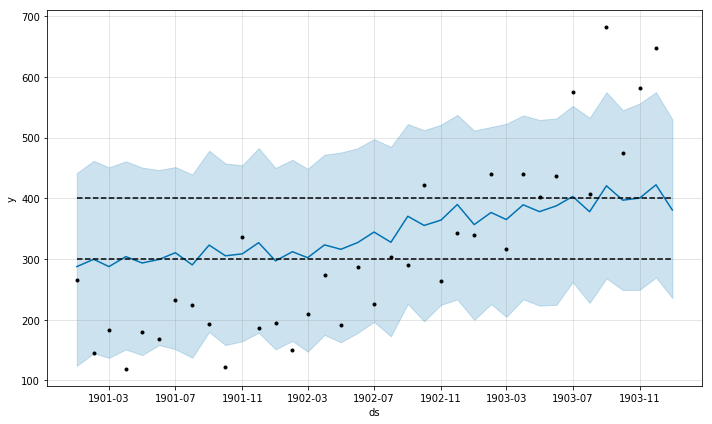

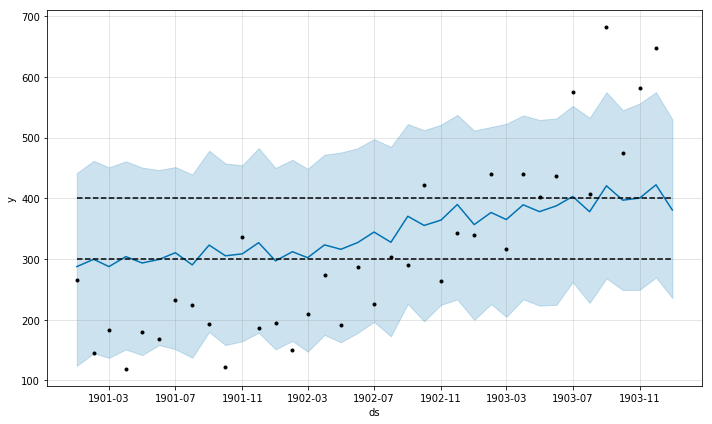

In [35]:
m.plot(forecast_data)

### outlier가 포함된 시계열 예측

In [36]:
dataset.loc[dataset['ds'] == '1902-07-01', 'y'] = 850
dataset.loc[dataset['ds'] == '1902-12-01', 'y'] = 10

In [37]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [38]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,548.703761,403.711937,697.432412
33,1903-10-01,469.533135,330.938568,613.416387
34,1903-11-01,523.177099,376.059272,662.304803
35,1903-12-01,415.586594,284.047661,551.806073
36,1903-12-31,502.178388,358.167302,642.274798


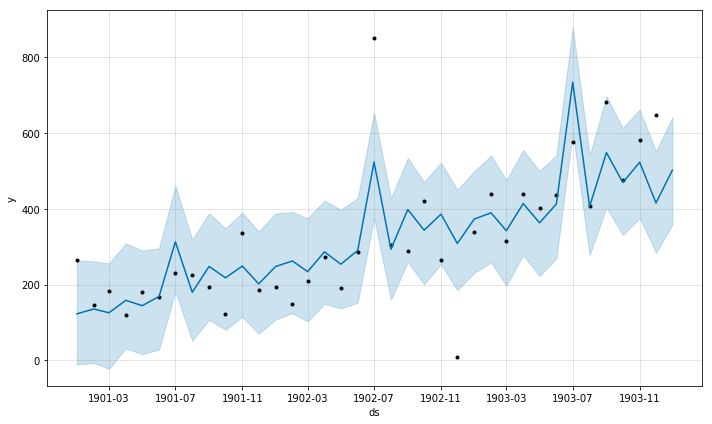

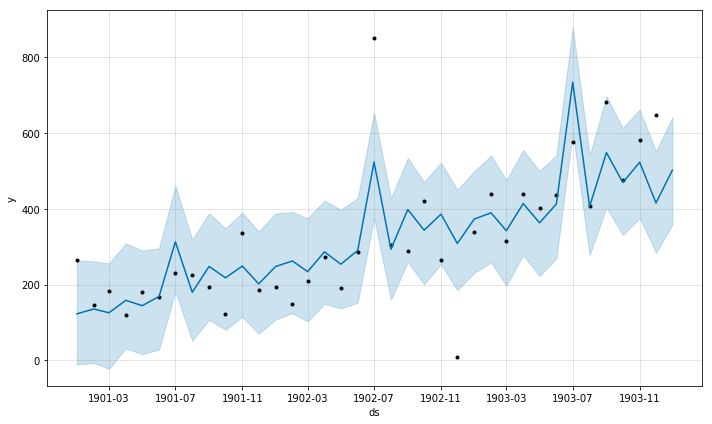

In [39]:
m.plot(forecast_data)

### rm outlier

In [40]:
dataset.loc[dataset['ds'] == '1902-07-01', 'y'] = None
dataset.loc[dataset['ds'] == '1902-12-01', 'y'] = None

In [41]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [42]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,575.752200,494.765027,650.683026
33,1903-10-01,488.268345,415.466835,565.511536
34,1903-11-01,535.208522,457.533264,608.438822
35,1903-12-01,602.970974,522.227912,684.585049
36,1903-12-31,484.517788,411.577392,561.738063


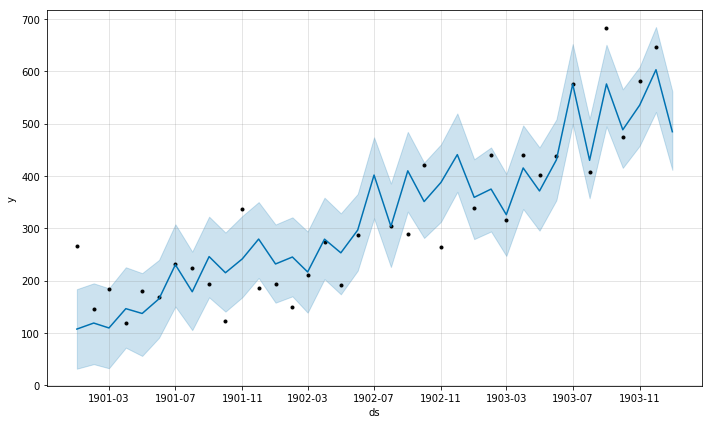

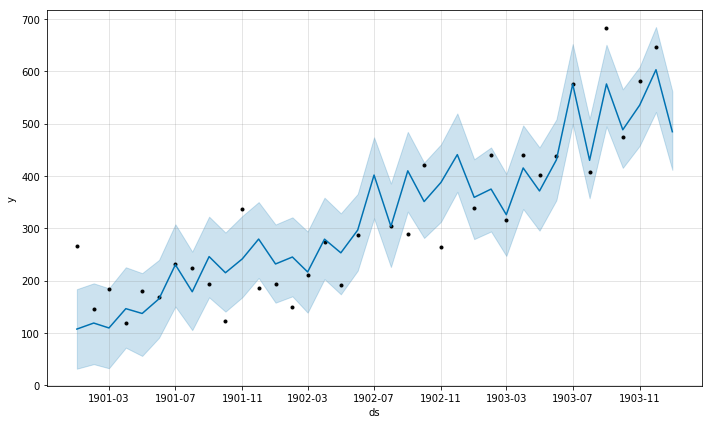

In [43]:
m.plot(forecast_data)

## Modeling 2. ARIMA(Autoregressive Integrated Moving Average)

- ARIMA는 Autoregressive Integrated Moving Average의 약자로, Autoregressive는 자기회귀 모형을 의미하고, Moving Average는 이동평균 모형을 의미한다.
- AR(Autoregression), 자기회귀 모형 : 이전의 자신의 관측값이 이후의 자신의 관측값에 영향을 준다는 아이디어의 모형이다. 큰 틀에서의 의미는 RNN과 완전히 동일하다. 다만, 선형적인 관계만을 정의하므로 정확하지는 않다.
- AR의 수식 : AR(1) -> Xt = theta * Xt-1 + et

- MA(Moving Average), 이동평균 모형 : 현재의 관측값이 이전의 관측 오차항에 영향을 받는다는 아이디어의 모형이다. 
- MA(1) -> Xt = et - B1 * et-1

- 이를 합한 ARMA 모형은 다음과 같다. 
- Xt=ϕXt−1+Wt+θWt−1
- 즉 정상성이 보장된다는 조건 하에 p차까지 자기회귀를 하고, 남은 잔차의 상관관계를 이용하여 오차항을 만들어내는 모형이다.
- ARIMA에서 I는 Integrated를 의미하는데, ARMA에서 시계열의 비정상성을 설명하기 위해 차분방정식의 개념을 도입하여 보정한 것을 의미하는 용어이다.

--------

- ARIMA의 하이퍼 파라미터는 3가지이다.
- (p, d , q)의 세 가지로, p와 q는 각각 AR, MA의 lag 개수를 의미하며 d는 차분의 횟수를 의미한다.

<img src="images/ARIMA.png">

### hyper parameter를 선정하는 방법
- ACF(Autocorrelation function) : Lag에 따른 관측치들 사이의 관련성을 측정하는 함수
- PACF(Partial autocorrelation function) : k 이외의 모든 다른 시점 관측치의 영향력을 배제하고 yt와 yt-k 두 관측치의 관련성을 측정하는 함수
- 두 그래프 중, 감소폭이나 증가폭이 완만한 그래프가 더 강한 영향을 미치는 것이라고 볼 수 있다.

- 시계열 데이터가 AR의 특성을 띄는 경우, ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소한다.
- 반대로, MA의 특성을 띄는 경우 ACF는 급격히 감소하고 PACF는 천천히 감소한다.
- 급격히 감소하는 시차를 각 AR과 MA 모형의 모수(p, q)로 사용할 수 있다. 
- 또한 데이터를 차분하여 ACF 및 PACF 계산함으로써 적절한 차분횟수까지 구할 수 있다

In [44]:
dataset = pd.read_csv(filename)
dataset.columns = ['Month', 'sale']
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
series = dataset

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


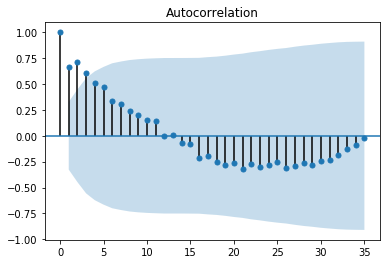

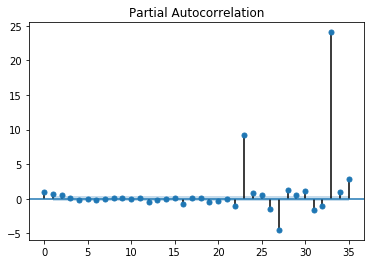

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(series)
plot_pacf(series)
plt.show()

#### ARIMA 모델링

In [46]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(4,1,0)) # P>|z| -> 학습 계수에 대한 p-value 값으로, (a,b,c) 일때 가장 적절한 조합을 찾아야 한다.
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.sale   No. Observations:                   35
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -196.393
Method:                       css-mle   S.D. of innovations             64.746
Date:                Wed, 29 Aug 2018   AIC                            404.787
Time:                        10:13:32   BIC                            414.119
Sample:                    02-01-1901   HQIC                           408.008
                         - 12-01-1903                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.1964      3.217      3.791      0.001       5.891      18.502
ar.L1.D.sale    -1.1456      0.176     -6.504      0.000      -1.491      -0.800
ar.L2.D.sale    -0.6921      0.264     -2.62

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimension

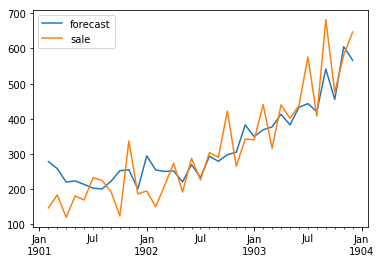

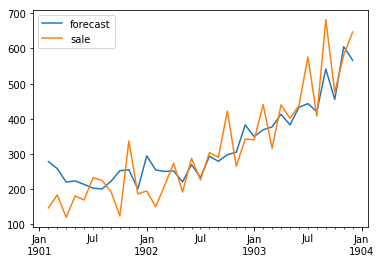

In [47]:
model_fit.plot_predict()

In [48]:
fore = model_fit.forecast(steps=3)
print(fore[0]) # 예측값

[562.5949631  664.01604686 591.62440332]


## Modeling 3. LSTM
### 3-1) multi-to-one step

In [49]:
import os
import math
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#### preprocessing for time-step forecasting

In [50]:
dataset = pd.read_csv(filename)
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
origin_series = dataset.values

"""
시계열 예측시에는 t, t-1 의 차이값을 value로 활용
"""
def difference(series, interval=1):
    diff = list()
    for i in range(interval, len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)

"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_ordered(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        train_len = int(x_data.shape[0] * (1 - test_size))
        x_train = x_data[:train_len, :]
        x_test = x_data[train_len:, :]
        y_train =  y_data[:train_len, :]
        y_test = y_data[train_len:, :]
        return (x_train, x_test, y_train, y_test)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)

"""
split origin dataset
"""
# def split_dataset():
    

# split origin dataset
origin_x_train, origin_x_test, origin_y_train, origin_y_test = make_timeseries_dataset_ordered(series=origin_series, x_steps=1, y_steps=1, test_size=0.4)
# transform original value to diff value
diff_series = difference(origin_series, 1)
# min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(diff_series)
# split and make timeseries
x_train, x_test, y_train, y_test = make_timeseries_dataset_ordered(series=scaled_series, x_steps=4, y_steps=1, test_size=0.4)

- print shape

In [51]:
print('training X data shape:', origin_x_train.shape)
print('training Y data shape:', origin_y_train.shape)
print('test X data shape:', origin_x_test.shape)
print('test Y data shape:', origin_y_test.shape)

training X data shape: (21, 1)
training Y data shape: (21, 1)
test X data shape: (14, 1)
test Y data shape: (14, 1)


In [52]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (18, 4)
training Y data shape: (18, 1)
test X data shape: (13, 4)
test Y data shape: (13, 1)


In [53]:
# data reshape : for trim batch size (train, predict in Neural Networks)
x_train = x_train[:16, :]
y_train = y_train[:16, :]
x_test = x_test[:12, :]
y_test = y_test[:12, :]

In [54]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (16, 4)
training Y data shape: (16, 1)
test X data shape: (12, 4)
test Y data shape: (12, 1)


- change shape for (LSTM or RNN)

In [55]:
"""
(size, timestep, feature) 의 형식으로 맞춰줘야 함
size : batch를 돌 데이터 사이즈
timestep : input의 time 개수 (X_t1, X_t2...)
feature : feature의 개수 (X = x1, x2 ...) [ex: x1 - 키, x2 - 몸무게 ...]
"""

time_step = 4
feature_num = 1

x_train_series = x_train.reshape(x_train.shape[0], time_step, feature_num)
x_test_series = x_test.reshape(x_test.shape[0], time_step, feature_num)

#### LSTM modeling code

In [56]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

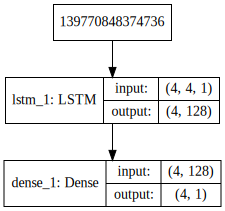

In [57]:
model = Sequential()
model.add(LSTM(128, batch_input_shape=(4, 4, 1), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

- return_sequences : many-to-many 문제나 lstm가 멀티 레이어인 경우 사용함. 각 time마다 y값을 출력 하느냐 마느냐의 결정.
- stateful : 상태유지모드 결정. 

#### stateful True

In [58]:
num_epochs = 500
batch_size=4

# simple lstm network learning
model = Sequential()
model.add(LSTM(3, batch_input_shape=(batch_size, time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train_series, y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

epochs : 0
Epoch 1/1
16/16 [==============================] - 0s 25ms/step - loss: 0.3234
epochs : 1
Epoch 1/1
16/16 [==============================] - 0s 499us/step - loss: 0.3067
epochs : 2
Epoch 1/1
16/16 [==============================] - 0s 472us/step - loss: 0.2910
epochs : 3
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.2763
epochs : 4
Epoch 1/1
16/16 [==============================] - 0s 530us/step - loss: 0.2625
epochs : 5
Epoch 1/1
16/16 [==============================] - 0s 608us/step - loss: 0.2496
epochs : 6
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.2376
epochs : 7
Epoch 1/1
16/16 [==============================] - 0s 497us/step - loss: 0.2265
epochs : 8
Epoch 1/1
16/16 [==============================] - 0s 758us/step - loss: 0.2161
epochs : 9
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.2065
epochs : 10
Epoch 1/1
16/16 [==============================] - 0s 775us/step - loss: 0.1975
epoch

16/16 [==============================] - 0s 634us/step - loss: 0.0318
epochs : 90
Epoch 1/1
16/16 [==============================] - 0s 483us/step - loss: 0.0317
epochs : 91
Epoch 1/1
16/16 [==============================] - 0s 455us/step - loss: 0.0317
epochs : 92
Epoch 1/1
16/16 [==============================] - 0s 588us/step - loss: 0.0316
epochs : 93
Epoch 1/1
16/16 [==============================] - 0s 476us/step - loss: 0.0316
epochs : 94
Epoch 1/1
16/16 [==============================] - 0s 671us/step - loss: 0.0316
epochs : 95
Epoch 1/1
16/16 [==============================] - 0s 735us/step - loss: 0.0315
epochs : 96
Epoch 1/1
16/16 [==============================] - 0s 483us/step - loss: 0.0315
epochs : 97
Epoch 1/1
16/16 [==============================] - 0s 570us/step - loss: 0.0314
epochs : 98
Epoch 1/1
16/16 [==============================] - 0s 605us/step - loss: 0.0314
epochs : 99
Epoch 1/1
16/16 [==============================] - 0s 878us/step - loss: 0.0314
epochs : 1

16/16 [==============================] - 0s 453us/step - loss: 0.0287
epochs : 178
Epoch 1/1
16/16 [==============================] - 0s 701us/step - loss: 0.0286
epochs : 179
Epoch 1/1
16/16 [==============================] - 0s 549us/step - loss: 0.0286
epochs : 180
Epoch 1/1
16/16 [==============================] - 0s 534us/step - loss: 0.0286
epochs : 181
Epoch 1/1
16/16 [==============================] - 0s 644us/step - loss: 0.0285
epochs : 182
Epoch 1/1
16/16 [==============================] - 0s 836us/step - loss: 0.0285
epochs : 183
Epoch 1/1
16/16 [==============================] - 0s 901us/step - loss: 0.0285
epochs : 184
Epoch 1/1
16/16 [==============================] - 0s 715us/step - loss: 0.0284
epochs : 185
Epoch 1/1
16/16 [==============================] - 0s 590us/step - loss: 0.0284
epochs : 186
Epoch 1/1
16/16 [==============================] - 0s 729us/step - loss: 0.0284
epochs : 187
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0283
ep

16/16 [==============================] - 0s 607us/step - loss: 0.0256
epochs : 266
Epoch 1/1
16/16 [==============================] - 0s 898us/step - loss: 0.0255
epochs : 267
Epoch 1/1
16/16 [==============================] - 0s 473us/step - loss: 0.0255
epochs : 268
Epoch 1/1
16/16 [==============================] - 0s 463us/step - loss: 0.0254
epochs : 269
Epoch 1/1
16/16 [==============================] - 0s 558us/step - loss: 0.0254
epochs : 270
Epoch 1/1
16/16 [==============================] - 0s 771us/step - loss: 0.0254
epochs : 271
Epoch 1/1
16/16 [==============================] - 0s 723us/step - loss: 0.0253
epochs : 272
Epoch 1/1
16/16 [==============================] - 0s 645us/step - loss: 0.0253
epochs : 273
Epoch 1/1
16/16 [==============================] - 0s 666us/step - loss: 0.0253
epochs : 274
Epoch 1/1
16/16 [==============================] - 0s 567us/step - loss: 0.0252
epochs : 275
Epoch 1/1
16/16 [==============================] - 0s 543us/step - loss: 0.0252


16/16 [==============================] - 0s 502us/step - loss: 0.0226
epochs : 354
Epoch 1/1
16/16 [==============================] - 0s 829us/step - loss: 0.0226
epochs : 355
Epoch 1/1
16/16 [==============================] - 0s 456us/step - loss: 0.0226
epochs : 356
Epoch 1/1
16/16 [==============================] - 0s 508us/step - loss: 0.0225
epochs : 357
Epoch 1/1
16/16 [==============================] - 0s 534us/step - loss: 0.0225
epochs : 358
Epoch 1/1
16/16 [==============================] - 0s 599us/step - loss: 0.0225
epochs : 359
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0224
epochs : 360
Epoch 1/1
16/16 [==============================] - 0s 626us/step - loss: 0.0224
epochs : 361
Epoch 1/1
16/16 [==============================] - 0s 631us/step - loss: 0.0224
epochs : 362
Epoch 1/1
16/16 [==============================] - 0s 586us/step - loss: 0.0224
epochs : 363
Epoch 1/1
16/16 [==============================] - 0s 572us/step - loss: 0.0223
ep

16/16 [==============================] - 0s 663us/step - loss: 0.0204
epochs : 442
Epoch 1/1
16/16 [==============================] - 0s 563us/step - loss: 0.0204
epochs : 443
Epoch 1/1
16/16 [==============================] - 0s 562us/step - loss: 0.0204
epochs : 444
Epoch 1/1
16/16 [==============================] - 0s 476us/step - loss: 0.0203
epochs : 445
Epoch 1/1
16/16 [==============================] - 0s 535us/step - loss: 0.0203
epochs : 446
Epoch 1/1
16/16 [==============================] - 0s 673us/step - loss: 0.0203
epochs : 447
Epoch 1/1
16/16 [==============================] - 0s 631us/step - loss: 0.0203
epochs : 448
Epoch 1/1
16/16 [==============================] - 0s 522us/step - loss: 0.0203
epochs : 449
Epoch 1/1
16/16 [==============================] - 0s 577us/step - loss: 0.0202
epochs : 450
Epoch 1/1
16/16 [==============================] - 0s 583us/step - loss: 0.0202
epochs : 451
Epoch 1/1
16/16 [==============================] - 0s 534us/step - loss: 0.0202


In [59]:
def show_train_fit():
    output = model.predict(x_train_series, batch_size=batch_size)
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat + origin_x_train[i+1]
        predictions.append(yhat)
    model.reset_states()
    return predictions

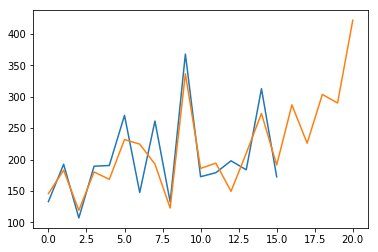

In [60]:
predictions = show_train_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_train) # yellow line
plt.show()

In [61]:
def show_test_fit():
    output = model.predict(x_test_series, batch_size=batch_size)
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat + origin_x_test[i+1]
        predictions.append(yhat)
    model.reset_states()
    return predictions

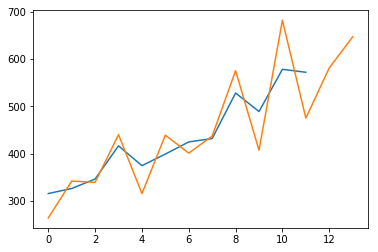

In [62]:
predictions = show_test_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_test) # yellow line
plt.show()

#### stateful False

In [65]:
num_epochs = 500
batch_size=4

# simple lstm network learning
model = Sequential()
model.add(LSTM(3, batch_input_shape=(batch_size, time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=False))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train_series, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=False)

Epoch 1/500
16/16 [==============================] - 1s 32ms/step - loss: 0.1436
Epoch 2/500
16/16 [==============================] - 0s 493us/step - loss: 0.1336
Epoch 3/500
16/16 [==============================] - 0s 829us/step - loss: 0.1240
Epoch 4/500
16/16 [==============================] - 0s 551us/step - loss: 0.1150
Epoch 5/500
16/16 [==============================] - 0s 778us/step - loss: 0.1065
Epoch 6/500
16/16 [==============================] - 0s 712us/step - loss: 0.0985
Epoch 7/500
16/16 [==============================] - 0s 566us/step - loss: 0.0911
Epoch 8/500
16/16 [==============================] - 0s 852us/step - loss: 0.0843
Epoch 9/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0780
Epoch 10/500
16/16 [==============================] - 0s 673us/step - loss: 0.0722
Epoch 11/500
16/16 [==============================] - 0s 593us/step - loss: 0.0669
Epoch 12/500
16/16 [==============================] - 0s 565us/step - loss: 0.0622
Epoch 13/500
16/

Epoch 100/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0313
Epoch 101/500
16/16 [==============================] - 0s 724us/step - loss: 0.0313
Epoch 102/500
16/16 [==============================] - 0s 789us/step - loss: 0.0312
Epoch 103/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0312
Epoch 104/500
16/16 [==============================] - 0s 614us/step - loss: 0.0311
Epoch 105/500
16/16 [==============================] - 0s 737us/step - loss: 0.0311
Epoch 106/500
16/16 [==============================] - 0s 784us/step - loss: 0.0310
Epoch 107/500
16/16 [==============================] - 0s 749us/step - loss: 0.0310
Epoch 108/500
16/16 [==============================] - 0s 809us/step - loss: 0.0309
Epoch 109/500
16/16 [==============================] - 0s 845us/step - loss: 0.0309
Epoch 110/500
16/16 [==============================] - 0s 680us/step - loss: 0.0309
Epoch 111/500
16/16 [==============================] - 0s 809us/step - loss: 0.0

16/16 [==============================] - 0s 553us/step - loss: 0.0270
Epoch 198/500
16/16 [==============================] - 0s 850us/step - loss: 0.0269
Epoch 199/500
16/16 [==============================] - 0s 578us/step - loss: 0.0269
Epoch 200/500
16/16 [==============================] - 0s 551us/step - loss: 0.0268
Epoch 201/500
16/16 [==============================] - 0s 685us/step - loss: 0.0268
Epoch 202/500
16/16 [==============================] - 0s 573us/step - loss: 0.0267
Epoch 203/500
16/16 [==============================] - 0s 622us/step - loss: 0.0267
Epoch 204/500
16/16 [==============================] - 0s 645us/step - loss: 0.0266
Epoch 205/500
16/16 [==============================] - 0s 644us/step - loss: 0.0266
Epoch 206/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0265
Epoch 207/500
16/16 [==============================] - 0s 725us/step - loss: 0.0265
Epoch 208/500
16/16 [==============================] - 0s 676us/step - loss: 0.0264
Epoch 20

16/16 [==============================] - 0s 664us/step - loss: 0.0216
Epoch 295/500
16/16 [==============================] - 0s 842us/step - loss: 0.0216
Epoch 296/500
16/16 [==============================] - 0s 679us/step - loss: 0.0215
Epoch 297/500
16/16 [==============================] - 0s 677us/step - loss: 0.0214
Epoch 298/500
16/16 [==============================] - 0s 830us/step - loss: 0.0213
Epoch 299/500
16/16 [==============================] - 0s 579us/step - loss: 0.0213
Epoch 300/500
16/16 [==============================] - 0s 784us/step - loss: 0.0212
Epoch 301/500
16/16 [==============================] - 0s 518us/step - loss: 0.0211
Epoch 302/500
16/16 [==============================] - 0s 610us/step - loss: 0.0211
Epoch 303/500
16/16 [==============================] - 0s 680us/step - loss: 0.0210
Epoch 304/500
16/16 [==============================] - 0s 652us/step - loss: 0.0209
Epoch 305/500
16/16 [==============================] - 0s 499us/step - loss: 0.0209
Epoch 

16/16 [==============================] - 0s 920us/step - loss: 0.0141
Epoch 393/500
16/16 [==============================] - 0s 513us/step - loss: 0.0140
Epoch 394/500
16/16 [==============================] - 0s 568us/step - loss: 0.0140
Epoch 395/500
16/16 [==============================] - 0s 939us/step - loss: 0.0139
Epoch 396/500
16/16 [==============================] - 0s 824us/step - loss: 0.0138
Epoch 397/500
16/16 [==============================] - 0s 760us/step - loss: 0.0137
Epoch 398/500
16/16 [==============================] - 0s 926us/step - loss: 0.0137
Epoch 399/500
16/16 [==============================] - 0s 879us/step - loss: 0.0136
Epoch 400/500
16/16 [==============================] - 0s 604us/step - loss: 0.0135
Epoch 401/500
16/16 [==============================] - 0s 499us/step - loss: 0.0135
Epoch 402/500
16/16 [==============================] - 0s 1ms/step - loss: 0.0134
Epoch 403/500
16/16 [==============================] - 0s 584us/step - loss: 0.0133
Epoch 40

16/16 [==============================] - 0s 640us/step - loss: 0.0102
Epoch 490/500
16/16 [==============================] - 0s 629us/step - loss: 0.0102
Epoch 491/500
16/16 [==============================] - 0s 571us/step - loss: 0.0102
Epoch 492/500
16/16 [==============================] - 0s 972us/step - loss: 0.0102
Epoch 493/500
16/16 [==============================] - 0s 786us/step - loss: 0.0101
Epoch 494/500
16/16 [==============================] - 0s 621us/step - loss: 0.0101
Epoch 495/500
16/16 [==============================] - 0s 696us/step - loss: 0.0101
Epoch 496/500
16/16 [==============================] - 0s 708us/step - loss: 0.0101
Epoch 497/500
16/16 [==============================] - 0s 505us/step - loss: 0.0101
Epoch 498/500
16/16 [==============================] - 0s 812us/step - loss: 0.0101
Epoch 499/500
16/16 [==============================] - 0s 553us/step - loss: 0.0101
Epoch 500/500
16/16 [==============================] - 0s 784us/step - loss: 0.0101


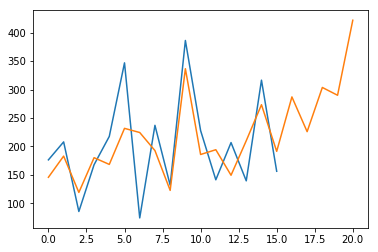

In [66]:
predictions = show_train_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_train) # yellow line
plt.show()

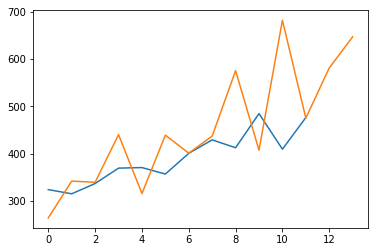

In [67]:
predictions = show_test_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_test) # yellow line
plt.show()